### Tidiness Score Model

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18

In [3]:
resnet = resnet18

model_path = 'data/classification-best/top_nobg_linspace_mse-best.pth'
device = "cuda:0"

model = resnet(pretrained=False)
fc_in_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_in_features, 1),
    #nn.Sigmoid()
)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

/home/gun/anaconda3/envs/diffuser/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gun/anaconda3/envs/diffuser/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Load Images

In [4]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [5]:
def get_scores(inputs):
    x_numpy = np.concatenate(inputs).reshape(-1, 360, 480, 3)
    x_tp = x_numpy.transpose([0, 3, 1, 2])
    x_eval = torch.from_numpy(x_tp).type(torch.float)
    X_eval = preprocess(x_eval).to(device)
    scores = model(X_eval)[:, 0].detach().cpu().numpy()
    return scores

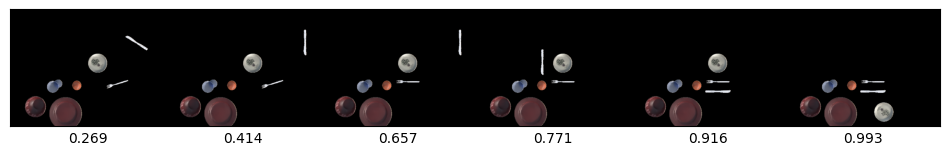

In [69]:
result_path = '/ssd/disk/PreferenceDiffusion/eval_ryan'
eval_name = 'mcts-0805_1542'
scene_name = 'scene-21'

data_path = os.path.join(result_path, eval_name, scene_name)
img_files = sorted([f for f in os.listdir(data_path) if f.startswith('nv_top_real')])
# sorted(os.listdir('/ssd/disk/PreferenceDiffusion/eval_ryan/mcts-0805_1542/scene-21'))


inputs = []
for img_file in img_files:
    img_path = os.path.join(data_path, img_file)
    img = np.array(Image.open(img_path))
    seg = np.array(Image.open(img_path.replace('nv_top_real_', 'top_seg_')))
    
    fg_mask = (1-(seg.sum(2)==334))
    img_rmbg = img * fg_mask[:, :, None]
    
    inputs.append(img_rmbg/255.)
scores = get_scores(inputs)

plt.figure(figsize=(12,4))
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

for k, score in enumerate(scores):
    plt.text(480*k+180, 360+50, '%.3f'%score, fontsize=10)
plt.imshow(np.concatenate(inputs, 1))
# plt.savefig('/ssd/disk/PreferenceDiffusion/user_study/%s=%s'%(eval_name, scene_name), bbox_inches='tight')
plt.show()

['mcts-0802_2103',
 'mcts-0802_2104',
 'mcts-0802_2105',
 'mcts-0803_0318',
 'mcts-0803_0734',
 'mcts-0803_0818',
 'mcts-0803_0959',
 'mcts-0803_1602',
 'mcts-0803_1821',
 'mcts-0803_1823',
 'mcts-0803_2243',
 'mcts-0804_0636',
 'mcts-0804_0743',
 'mcts-0804_1917',
 'mcts-0804_1918',
 'mcts-0805_0514',
 'mcts-0805_0518',
 'mcts-0805_1457',
 'mcts-0805_1542',
 'mcts-0806_0315',
 'mcts-0806_0533',
 'mcts-0806_1519',
 'mcts-0806_1559']

/tmp/ipykernel_31590/3405658649.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,4))


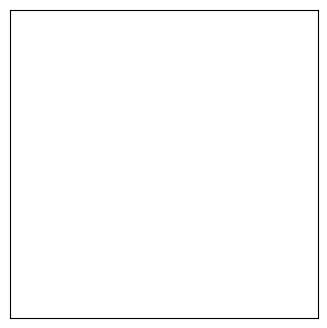

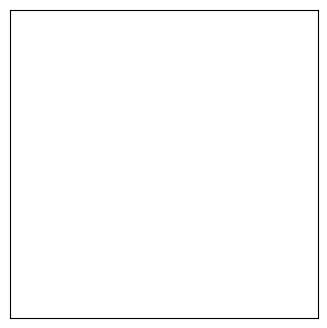

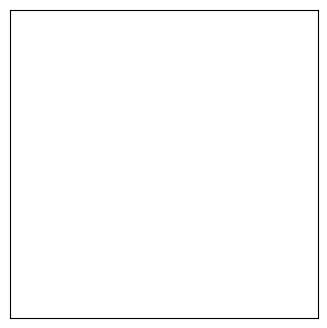

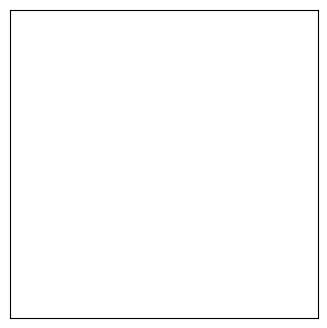

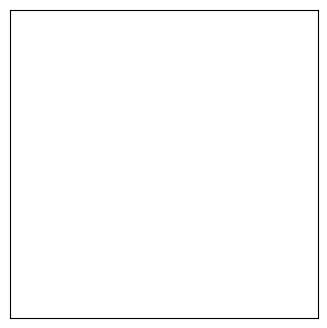

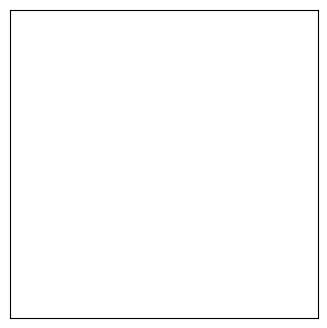

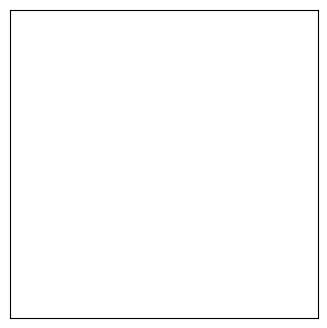

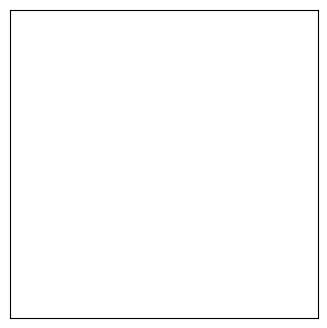

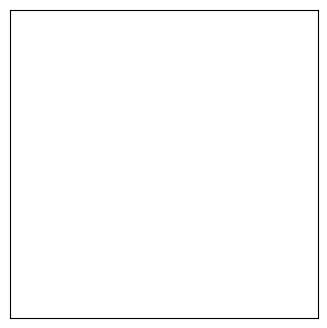

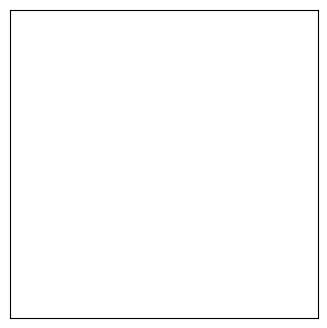

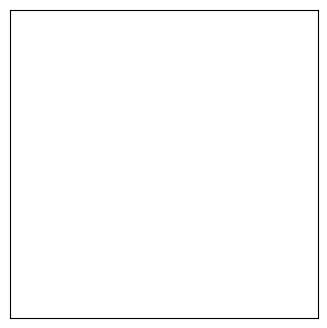

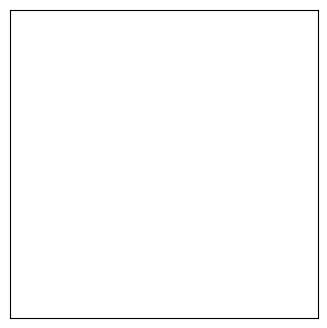

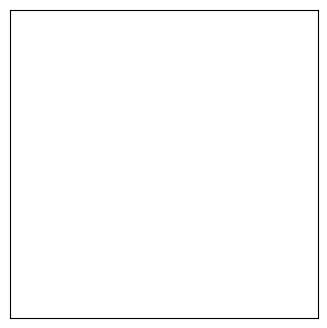

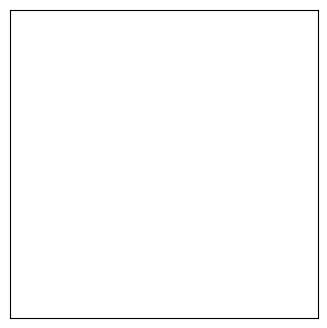

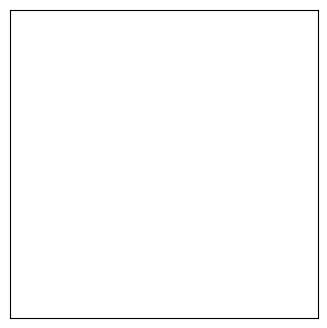

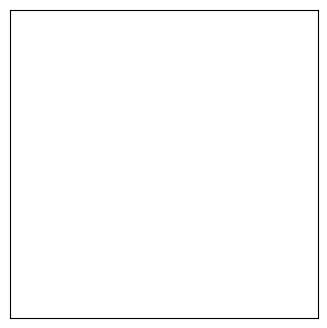

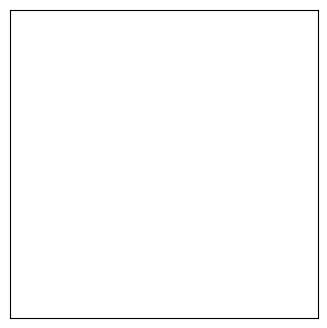

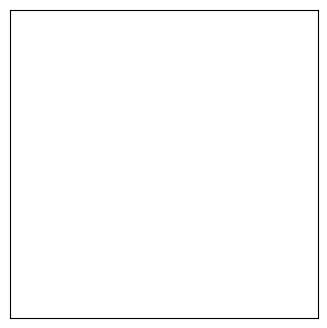

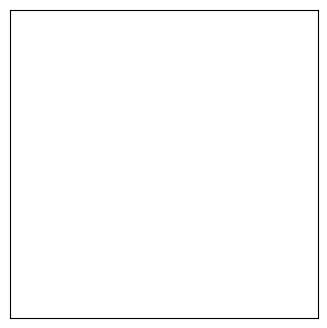

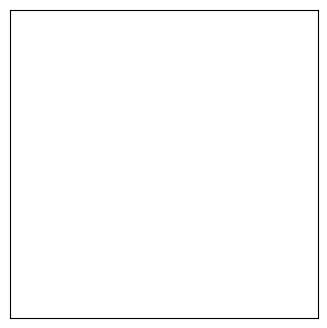

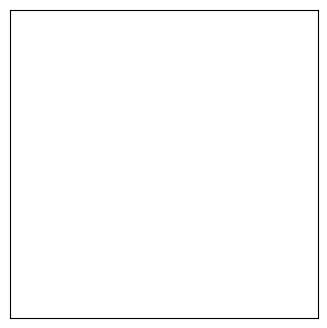

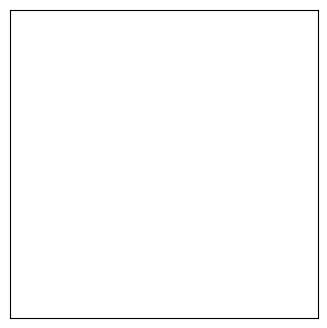

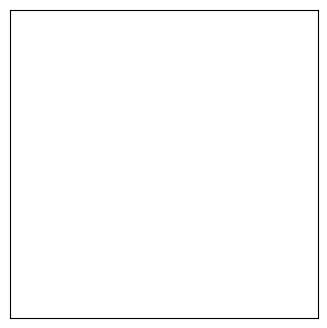

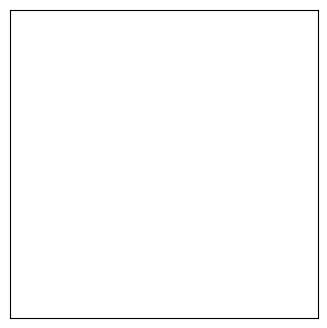

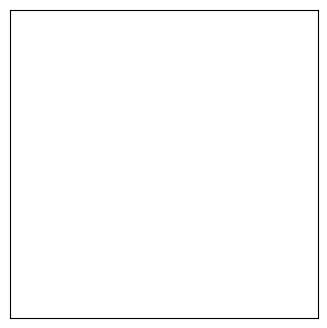

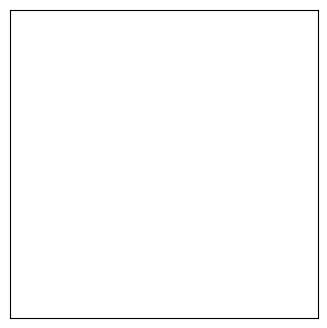

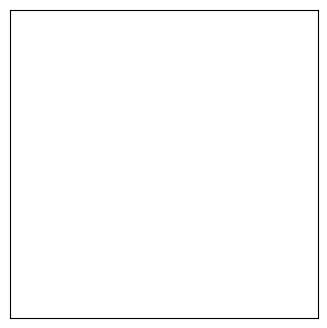

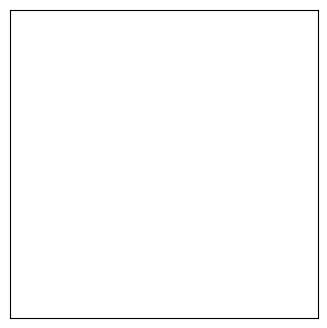

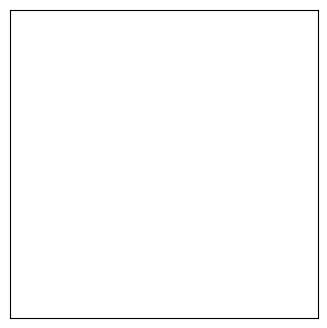

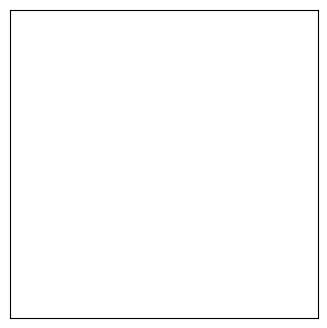

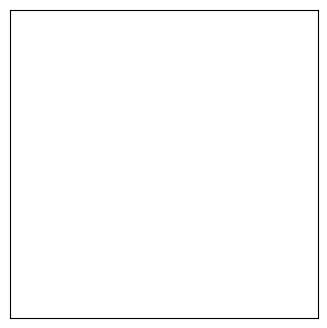

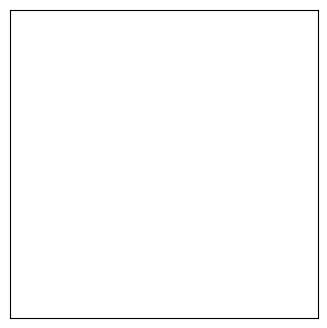

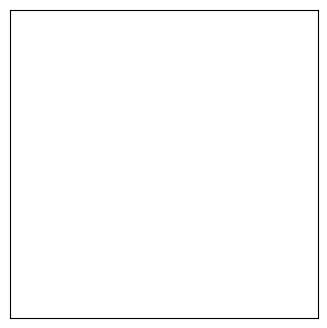

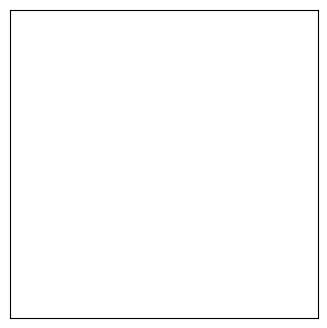

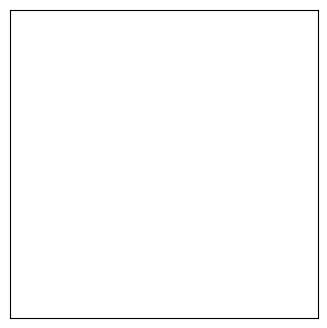

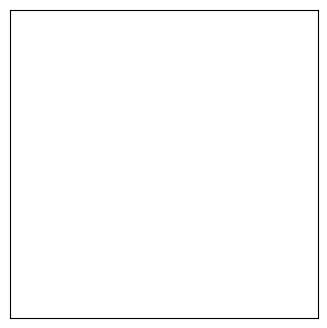

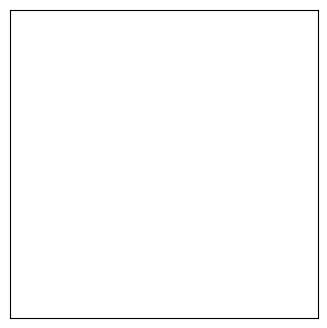

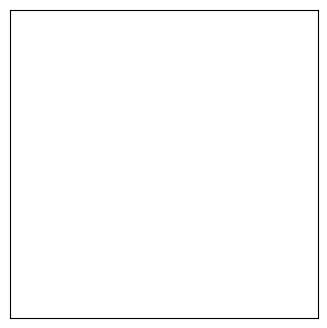

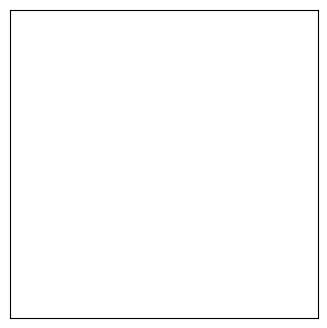

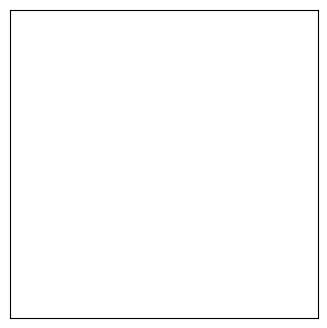

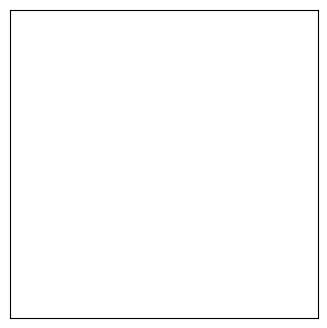

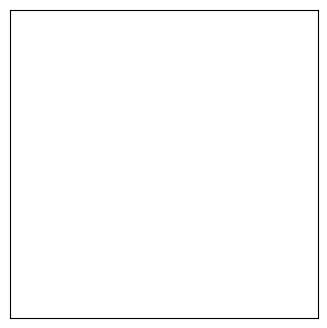

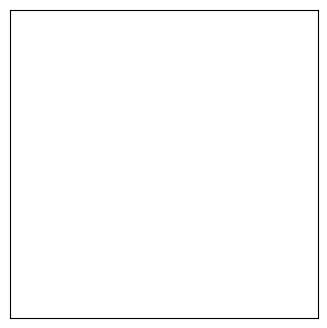

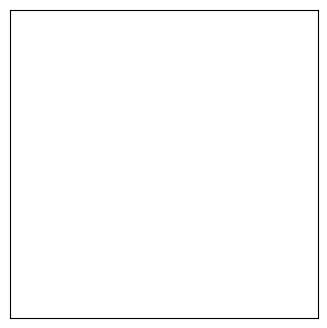

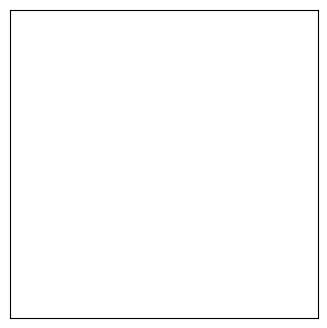

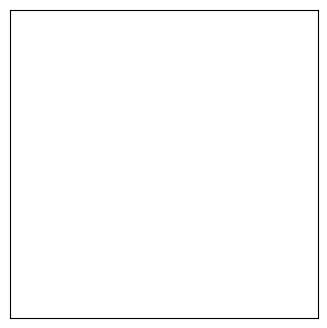

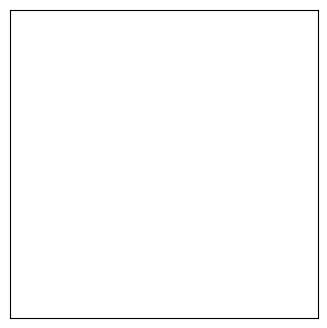

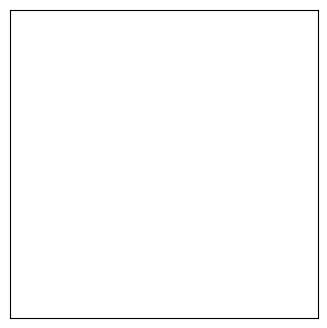

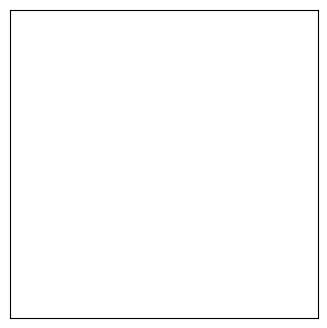

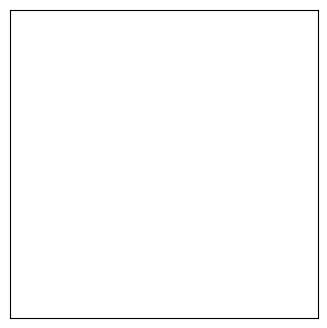

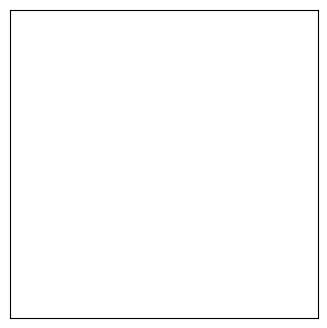

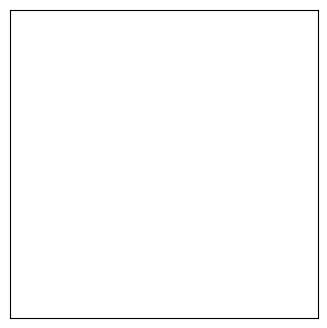

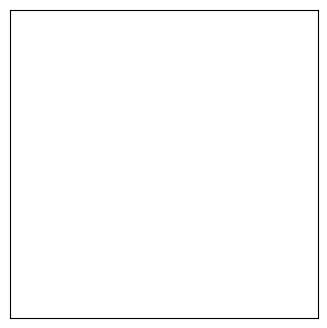

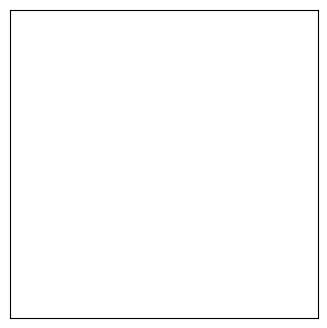

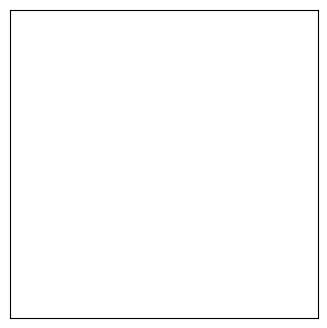

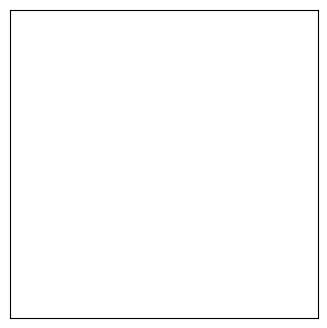

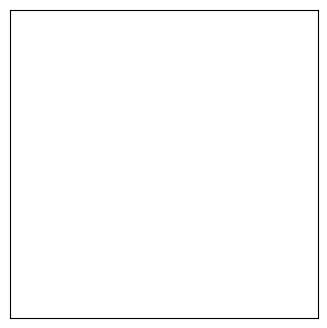

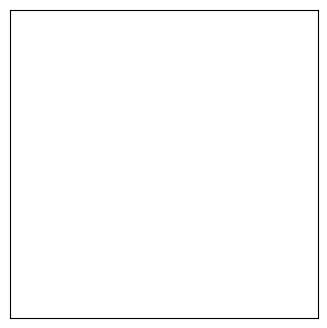

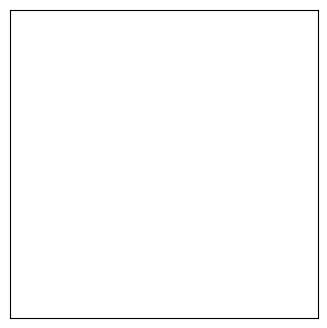

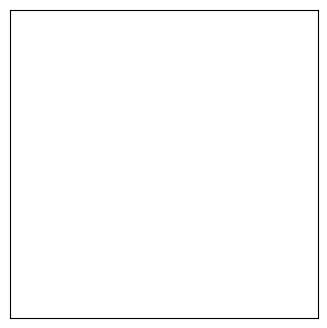

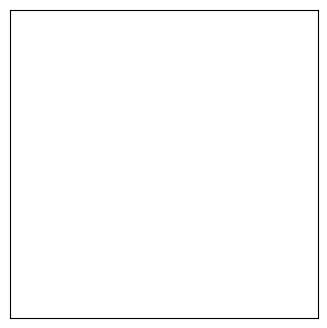

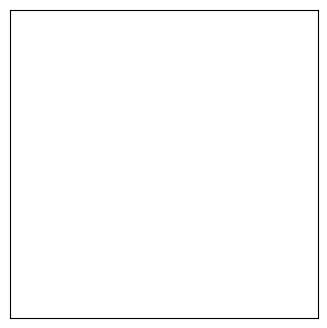

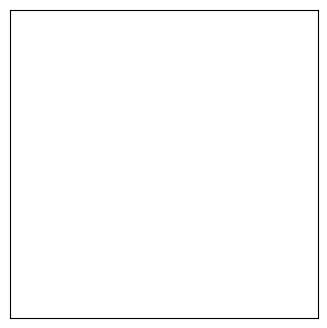

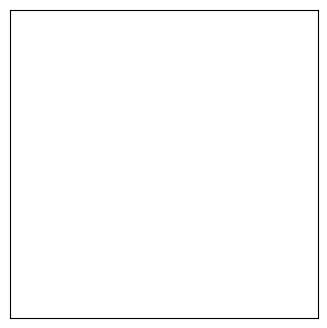

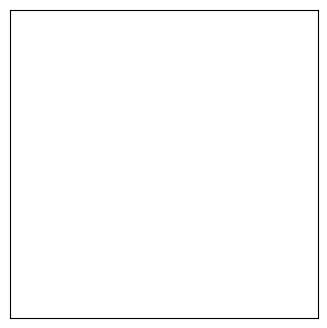

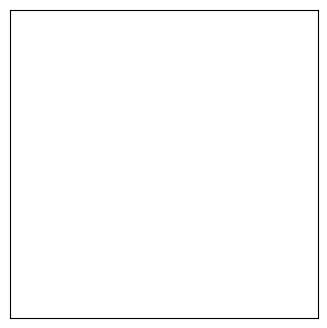

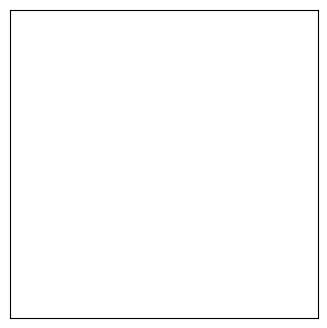

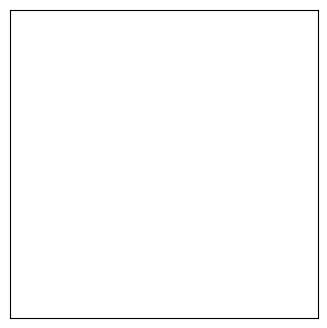

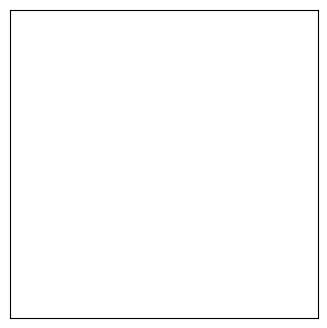

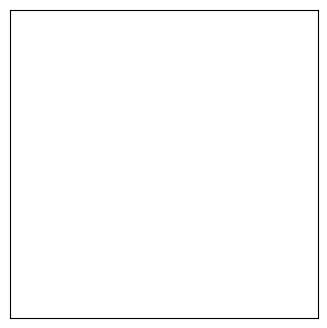

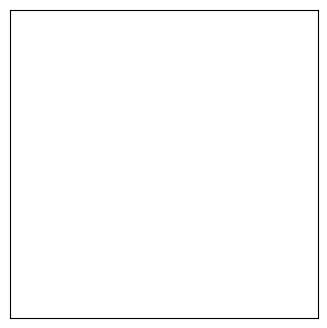

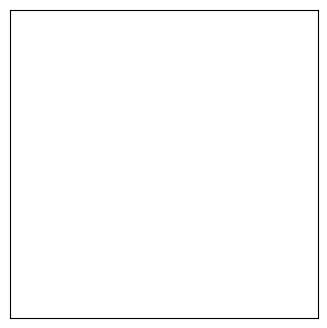

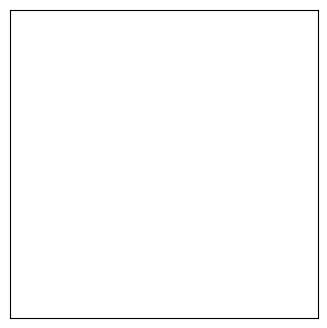

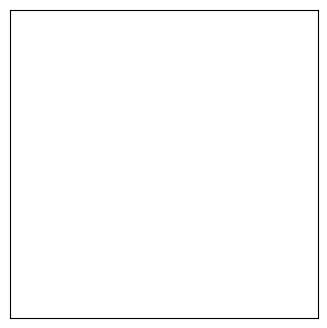

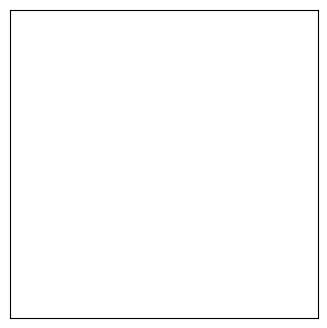

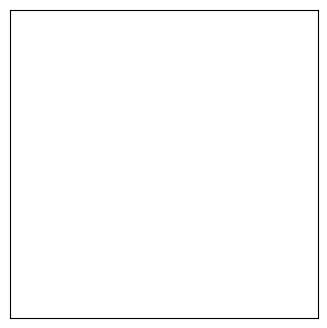

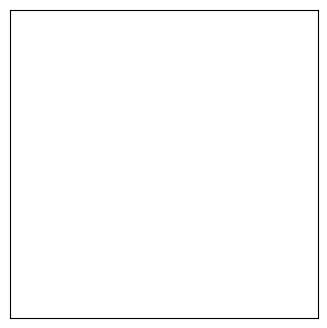

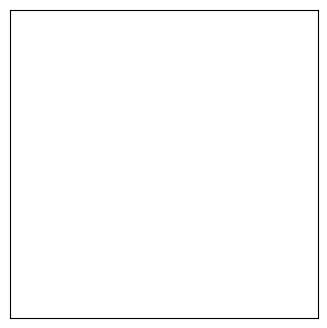

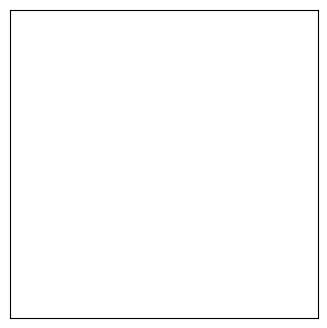

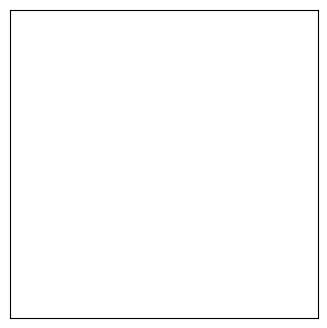

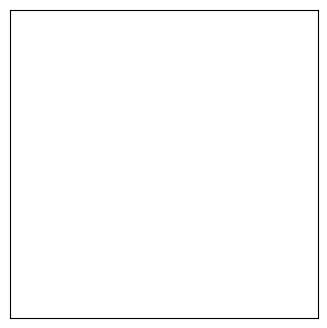

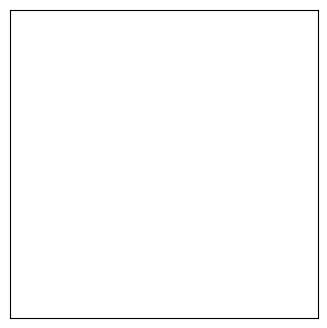

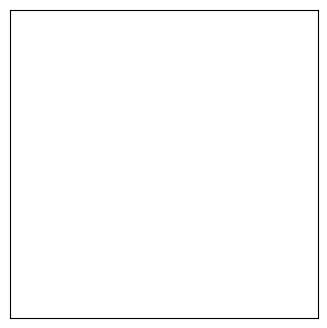

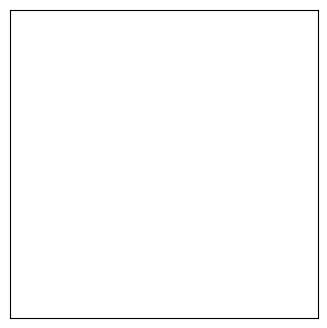

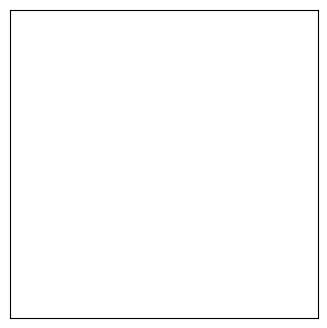

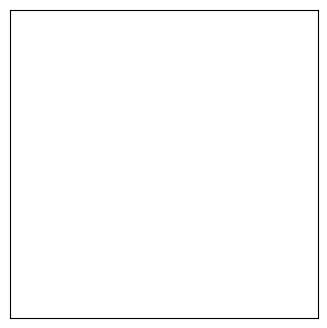

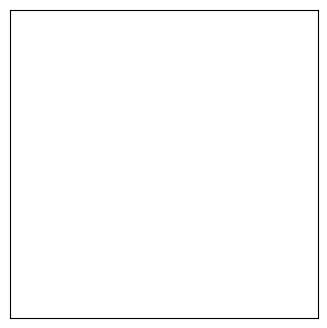

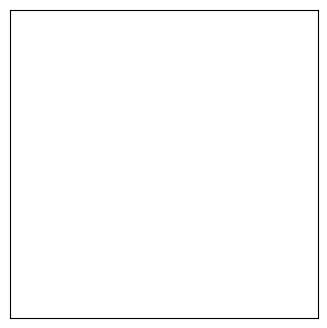

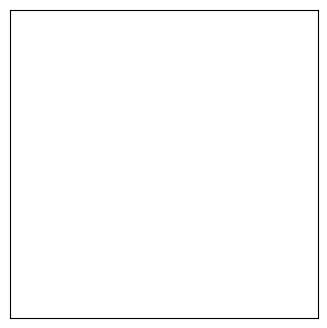

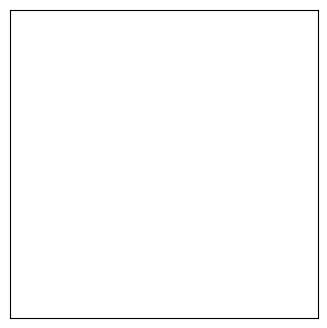

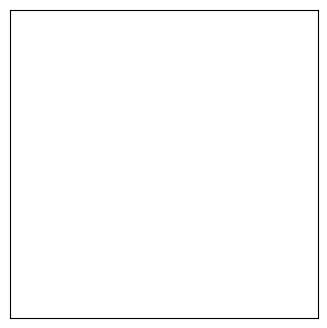

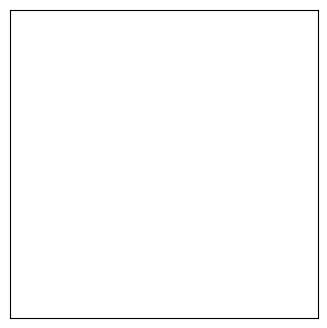

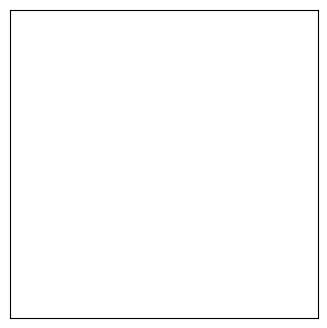

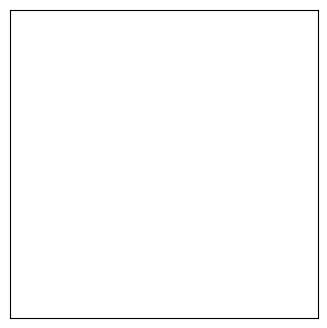

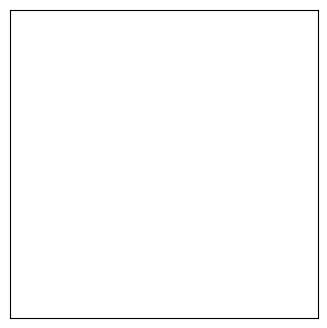

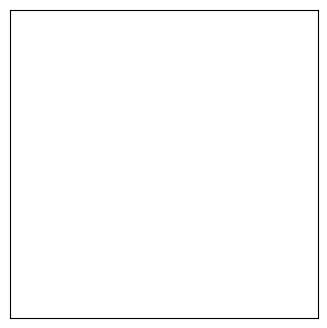

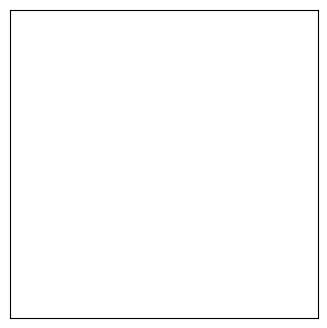

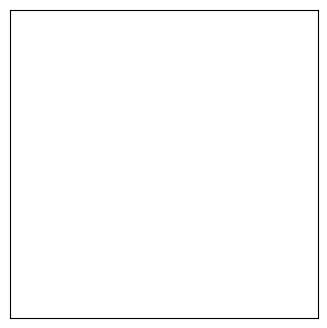

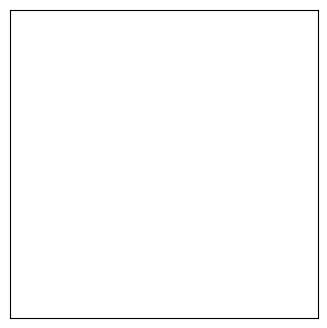

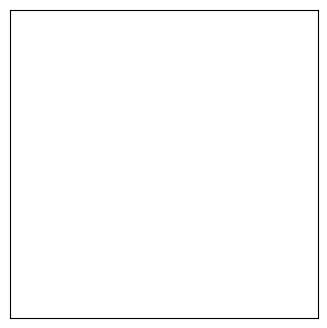

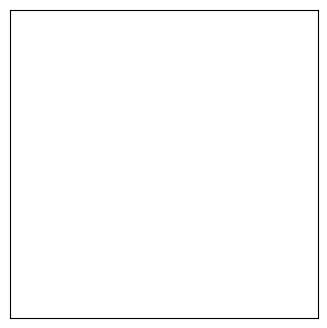

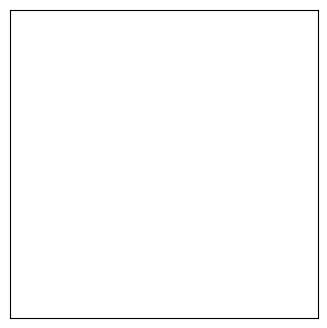

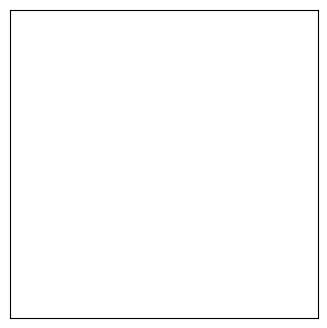

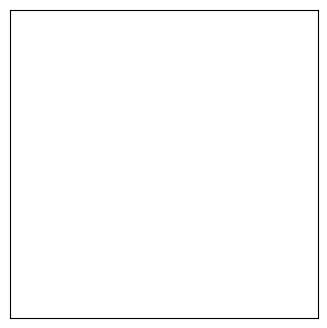

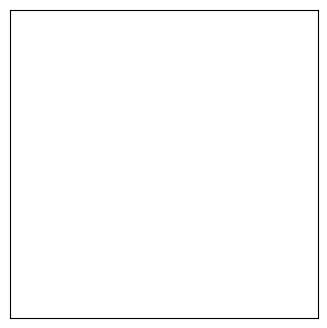

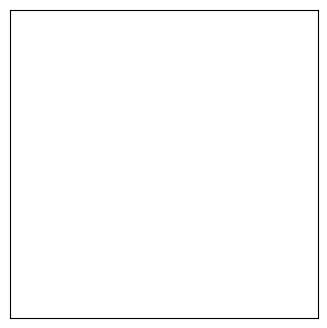

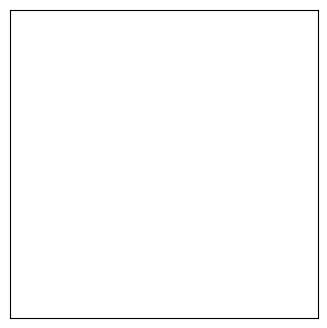

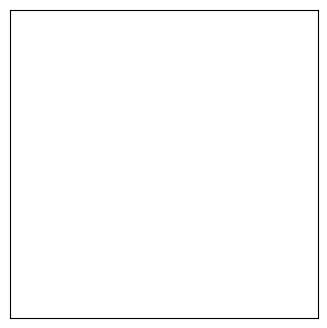

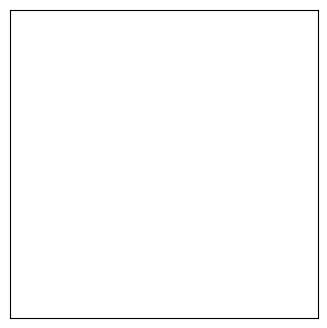

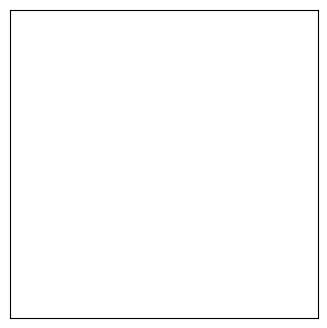

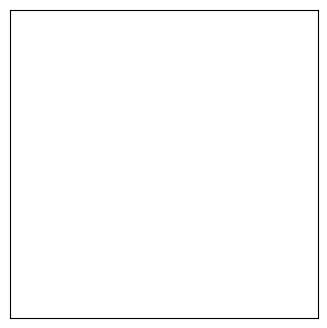

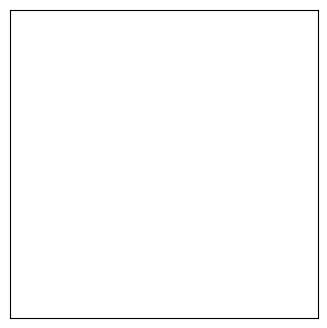

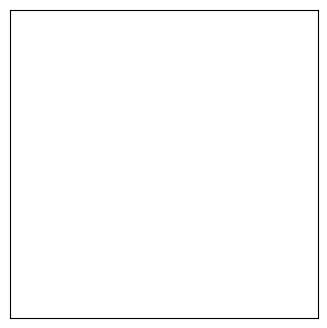

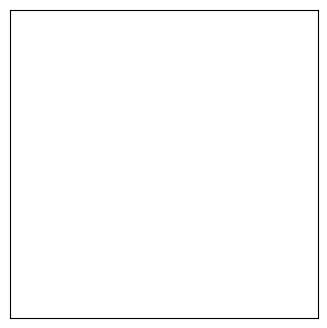

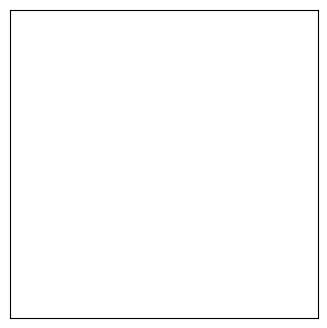

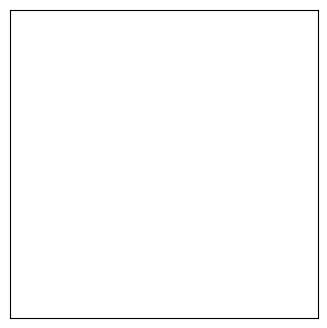

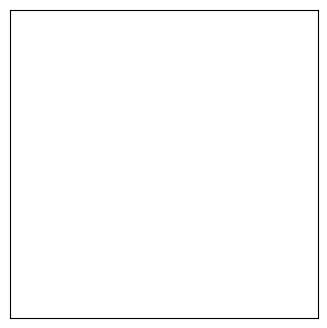

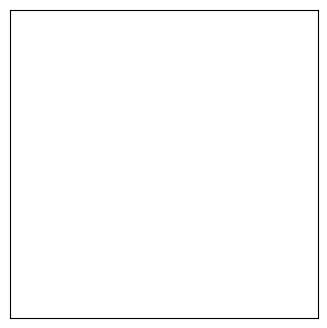

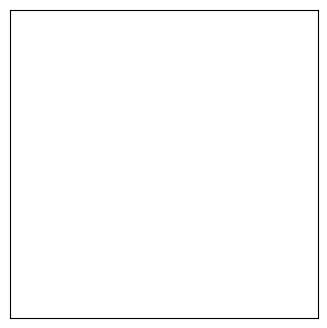

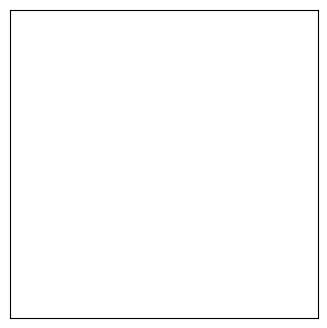

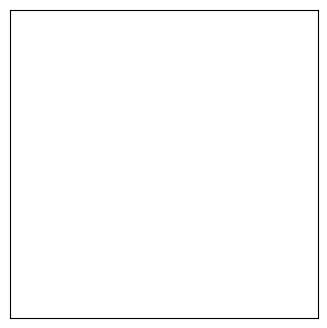

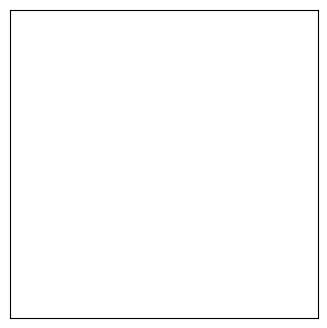

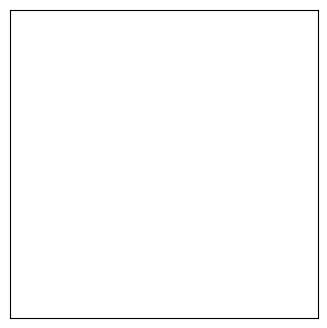

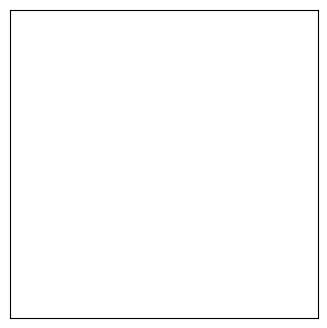

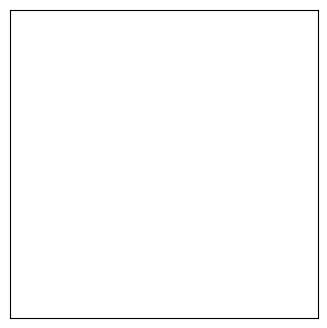

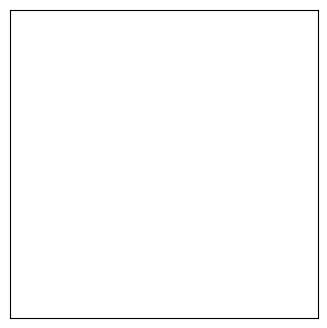

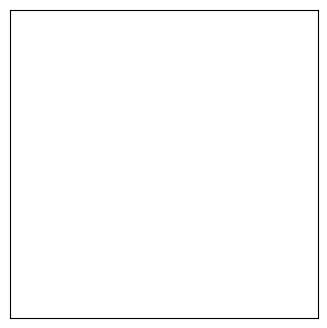

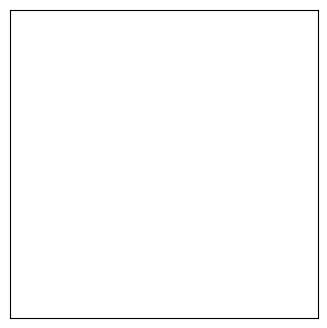

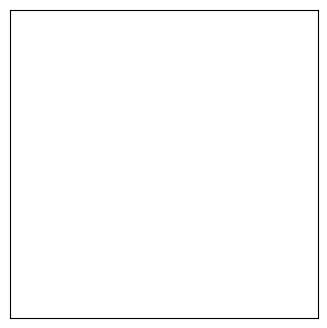

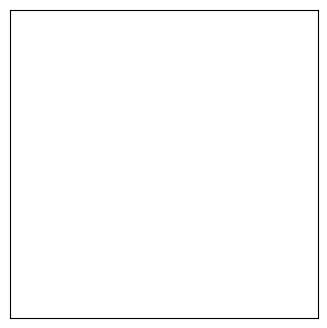

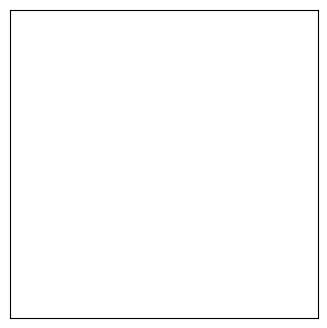

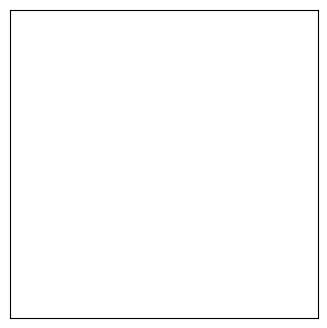

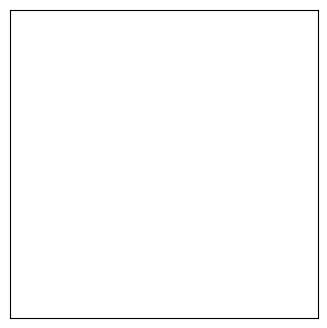

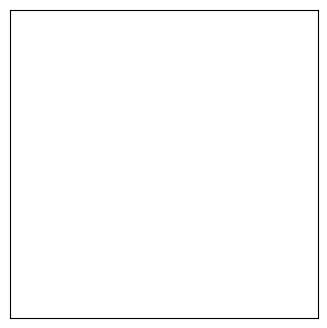

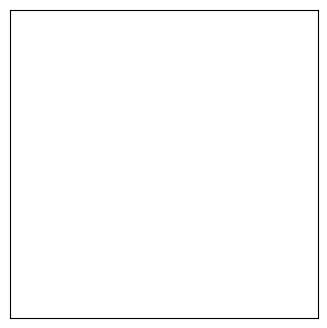

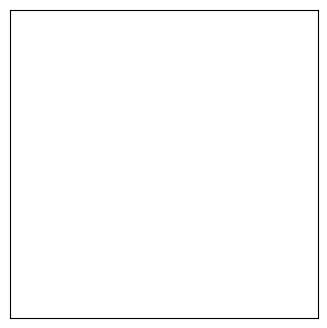

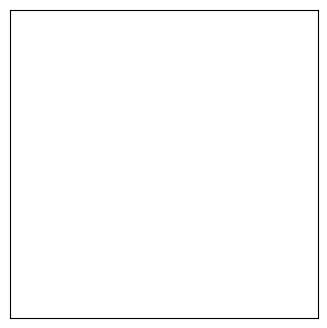

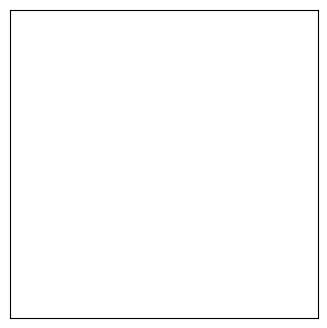

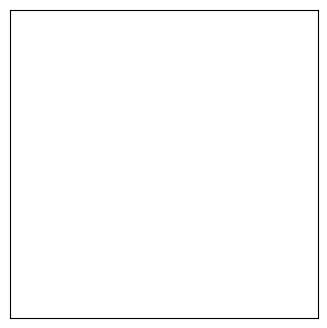

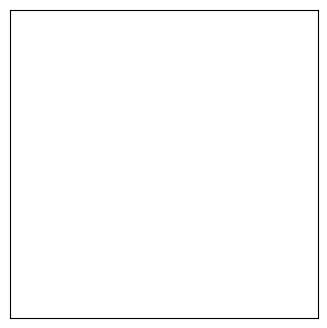

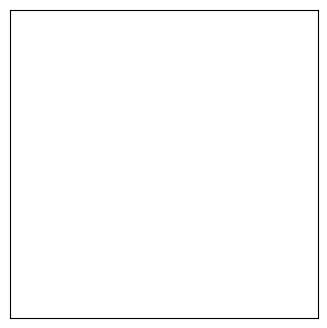

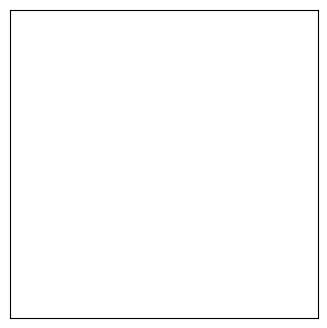

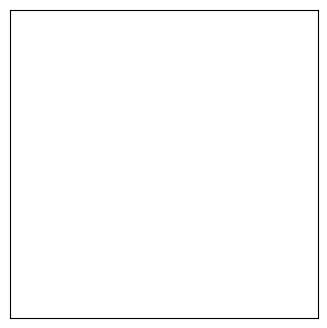

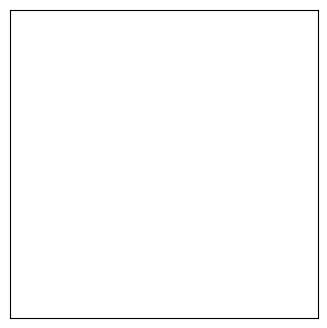

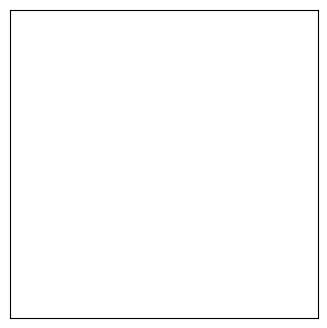

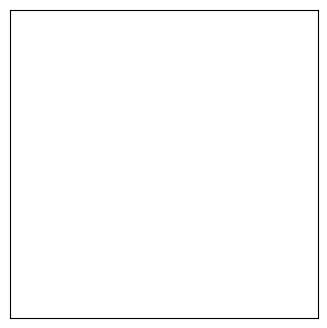

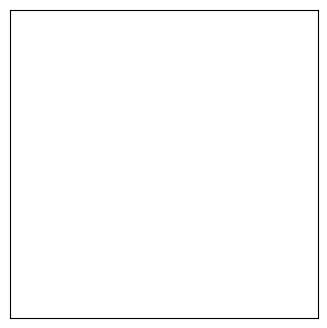

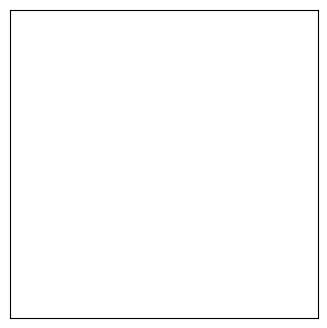

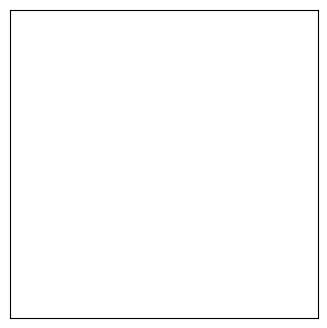

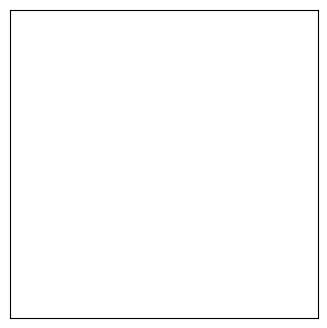

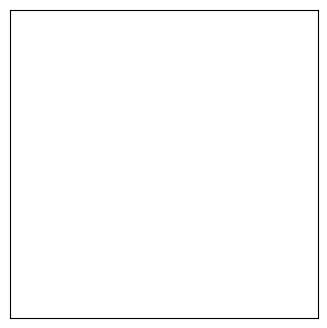

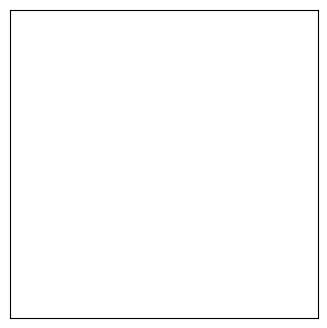

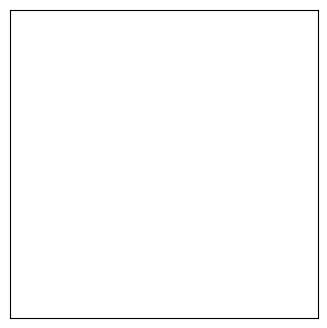

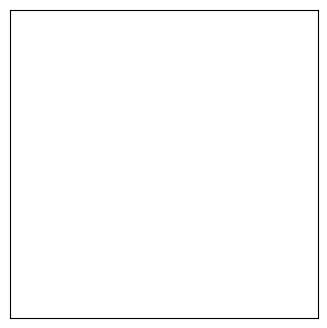

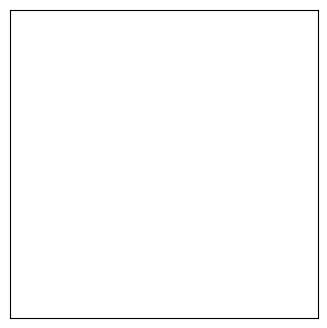

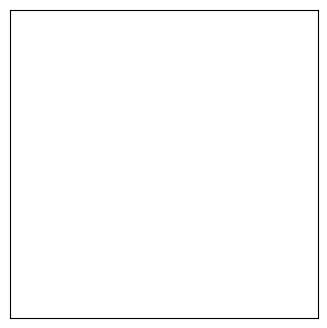

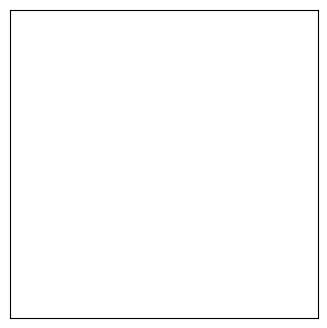

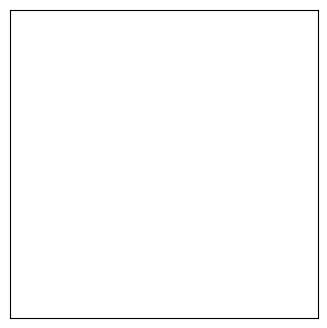

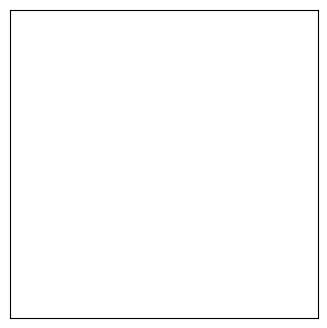

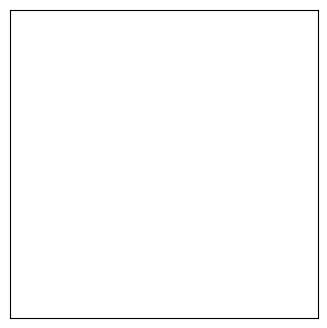

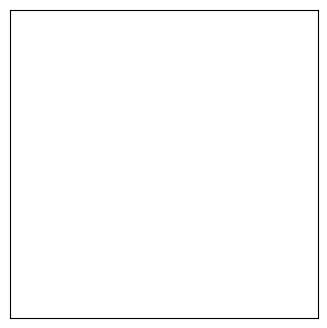

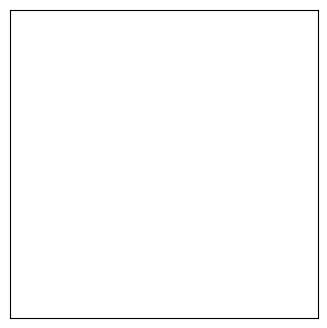

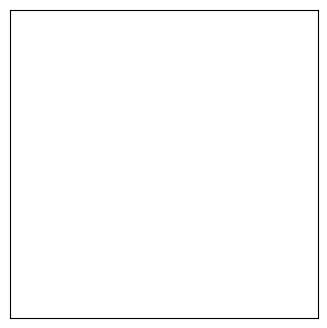

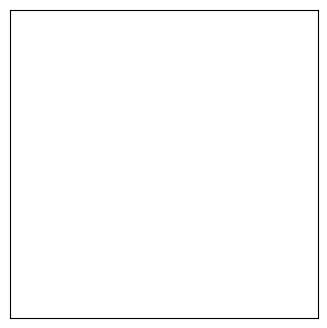

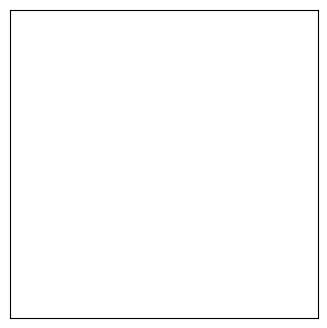

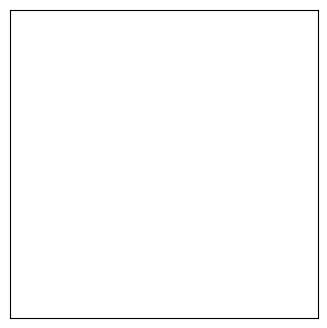

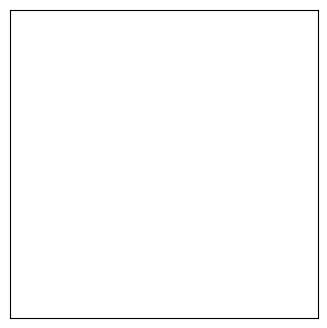

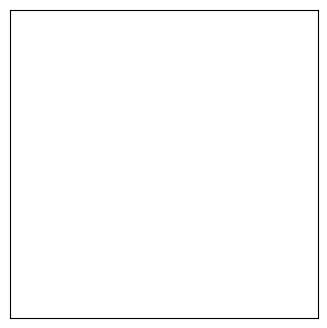

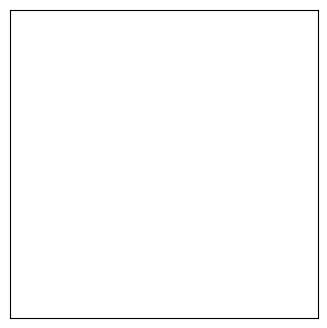

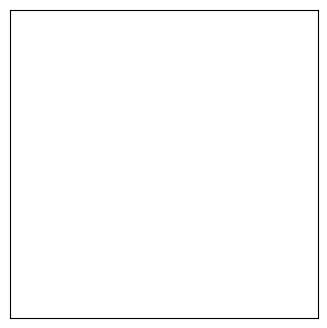

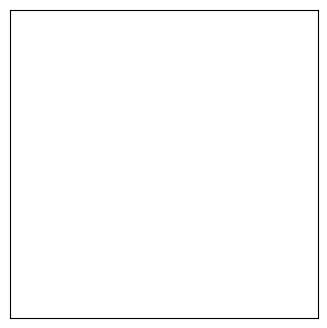

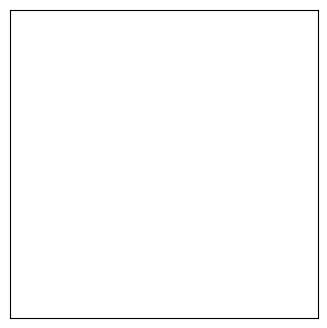

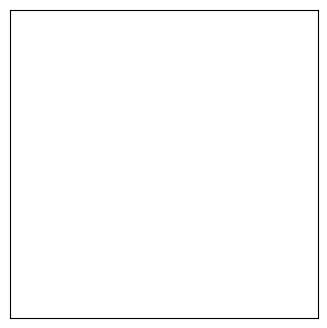

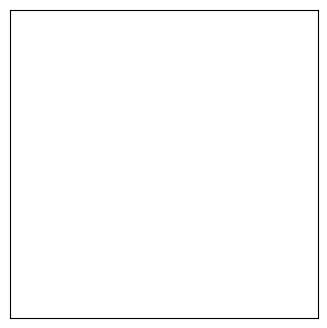

In [86]:
result_path = '/ssd/disk/PreferenceDiffusion/eval_ryan'

# eval_name = 'mcts-0805_1542'
# scene_name = 'scene-21'

#for eval_name in tqdm(sorted([d for d in os.listdir(result_path) if d.startswith('mcts-')])):
for eval_name in ['mcts-0803_0734', 'mcts-0803_0959', 'mcts-0803_1602', 'mcts-0802_2103']:
    #for scene_name in sorted([s for s in os.listdir(os.path.join(result_path, eval_name)) if s.startswith('scene-')]):
    for sidx in np.random.choice(np.arange(100), 50):
        scene_name = 'scene-%d'%sidx
    
        data_path = os.path.join(result_path, eval_name, scene_name)
        img_files = sorted([f for f in os.listdir(data_path) if f.startswith('nv_top_real')])
        
        images = []
        inputs = []
        for img_file in img_files:
            img_path = os.path.join(data_path, img_file)
            img = np.array(Image.open(img_path))
            seg = np.array(Image.open(img_path.replace('nv_top_real_', 'top_seg_')))

            fg_mask = (1-(seg.sum(2)==334))
            img_rmbg = img * fg_mask[:, :, None]

            images.append(img)
            inputs.append(img_rmbg/255.)
        scores = get_scores(inputs)
        if len(scores) < 4:
            continue

        plt.figure(figsize=(12,4))
        plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

        for k, score in enumerate(scores):
            plt.text(480*k+180, 360+50, '%.3f'%score, fontsize=10)
        plt.imshow(np.concatenate(images, 1))
        # plt.imshow(np.concatenate(inputs, 1))
        if not os.path.isdir('/ssd/disk/PreferenceDiffusion/user_study/%s'%eval_name):
            os.makedirs('/ssd/disk/PreferenceDiffusion/user_study/%s'%eval_name)
        plt.savefig('/ssd/disk/PreferenceDiffusion/user_study/%s/%s'%(eval_name, scene_name), bbox_inches='tight')
        plt.cla()

/tmp/ipykernel_23911/726404982.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12,4))


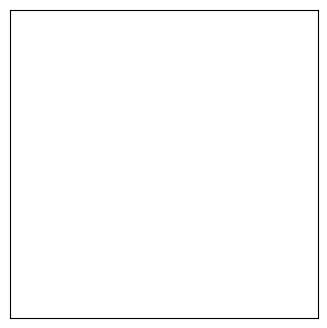

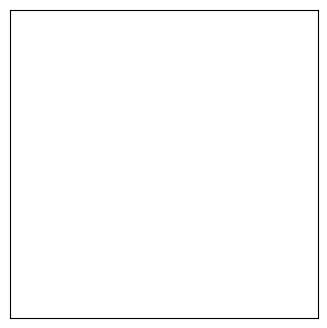

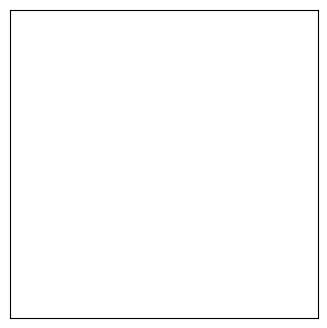

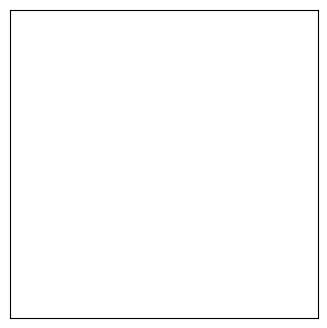

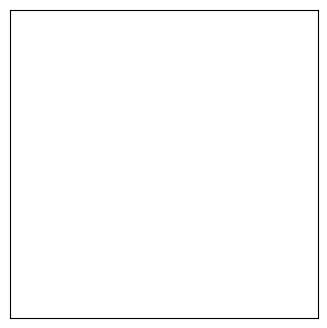

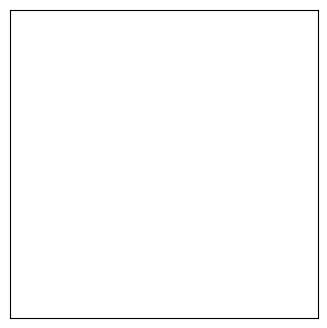

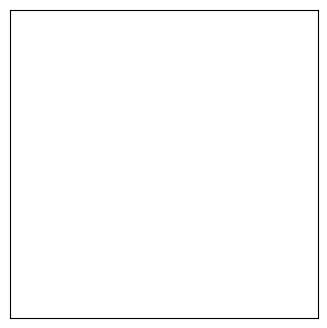

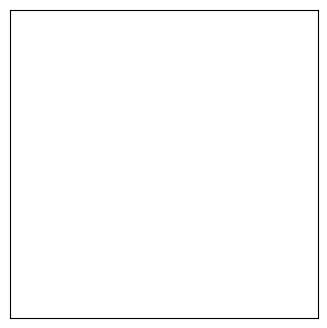

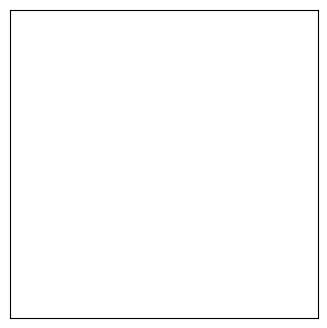

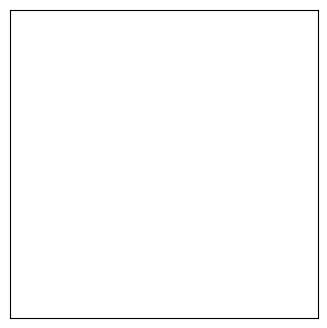

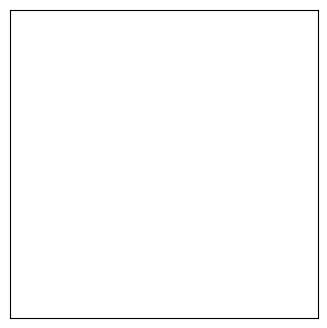

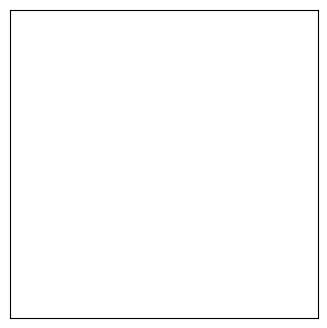

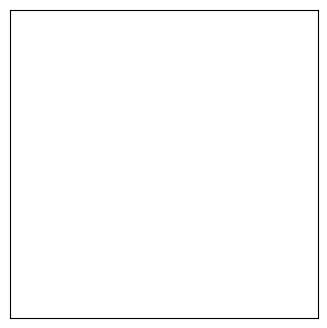

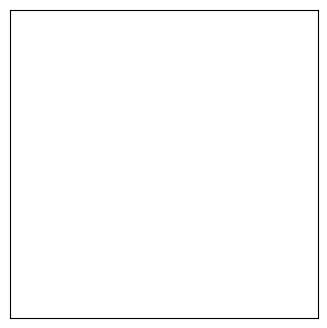

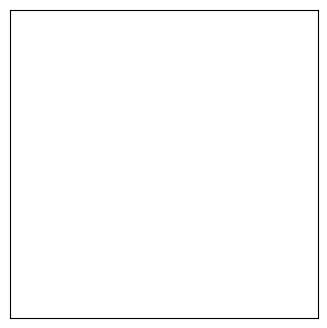

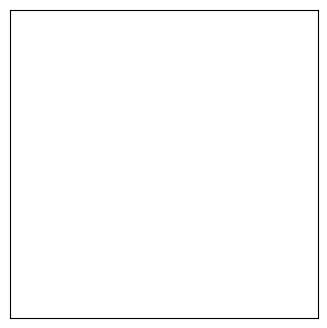

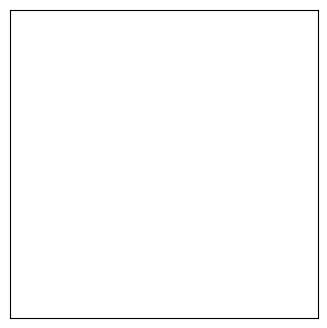

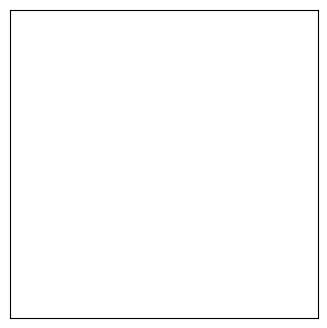

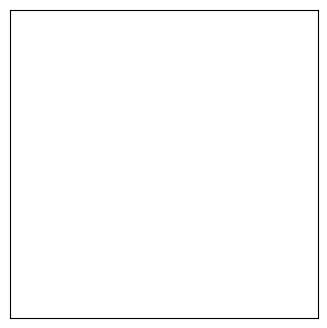

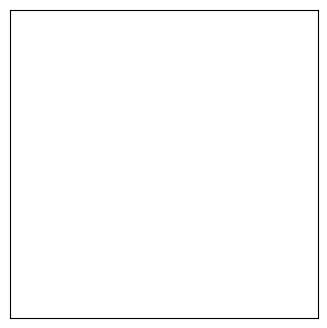

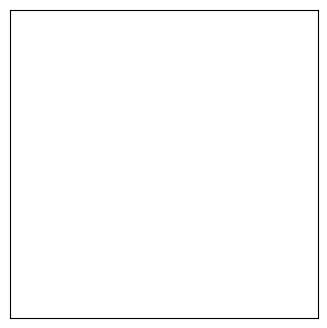

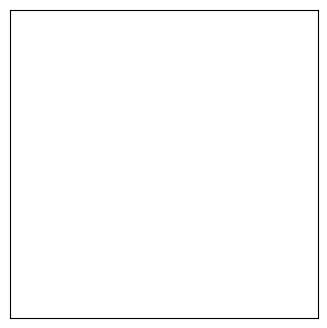

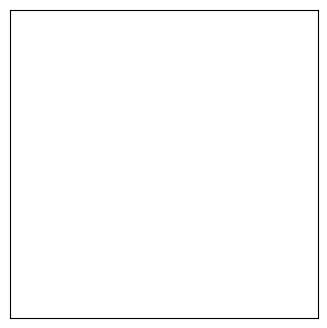

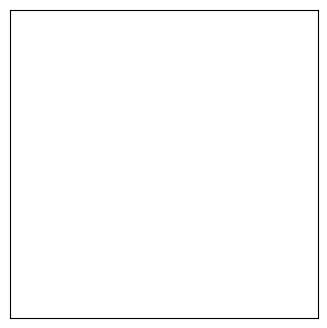

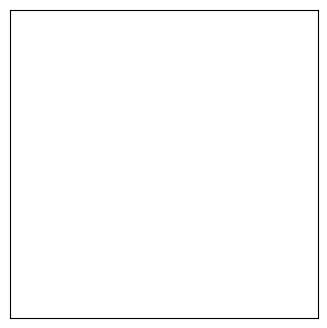

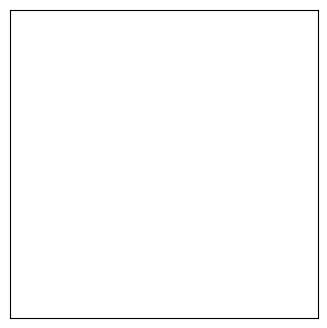

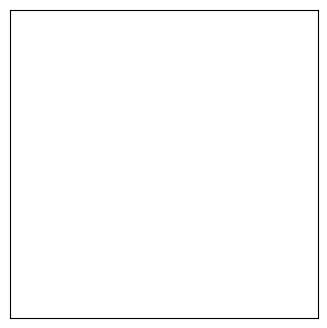

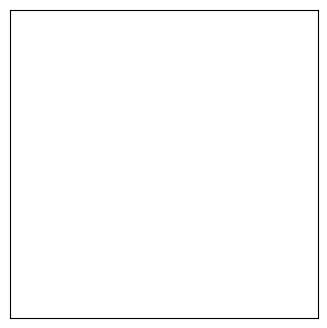

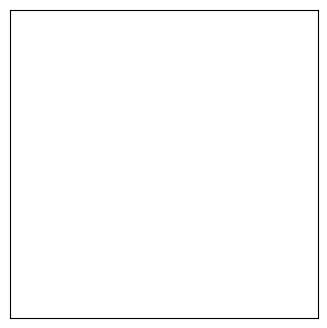

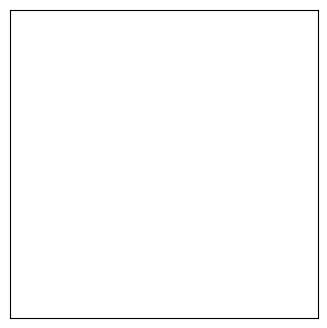

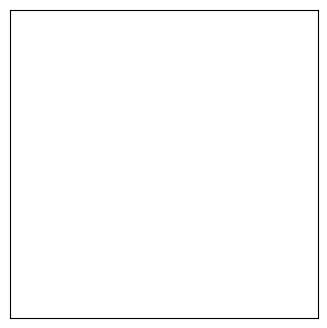

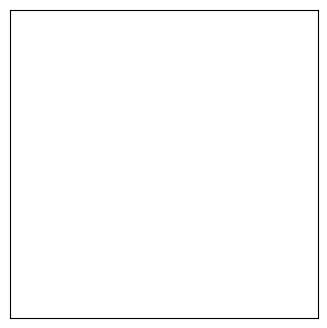

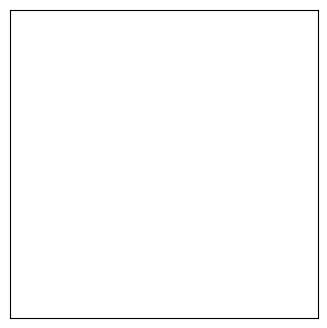

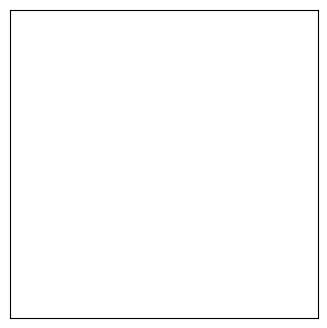

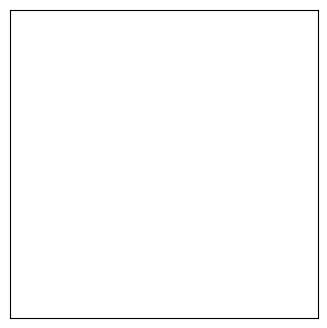

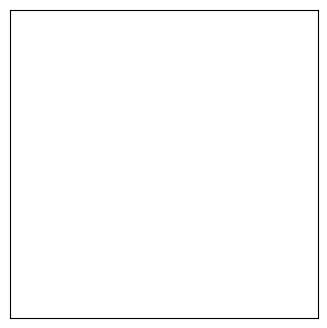

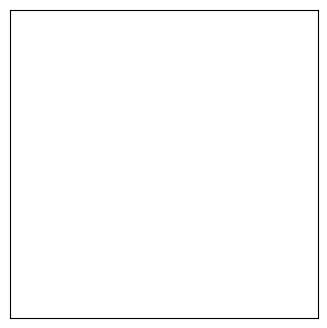

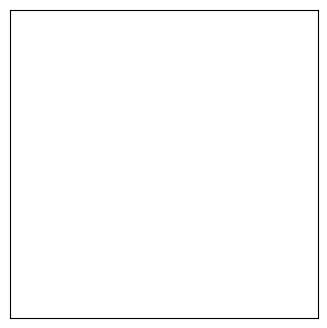

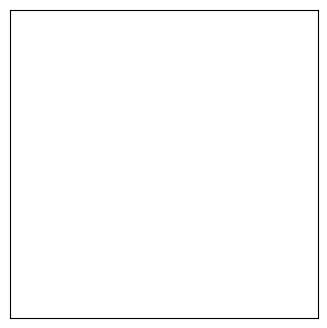

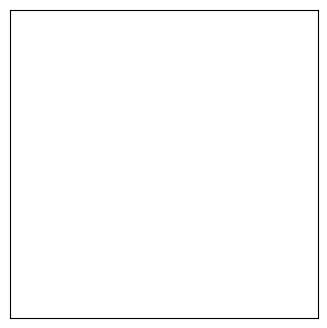

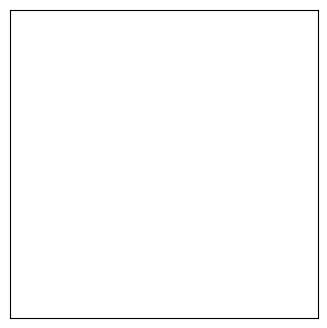

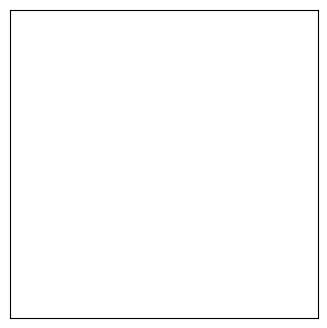

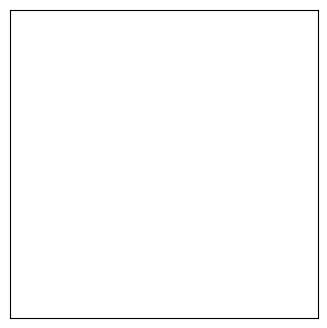

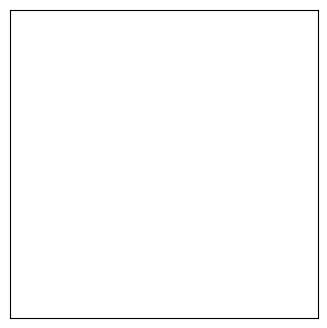

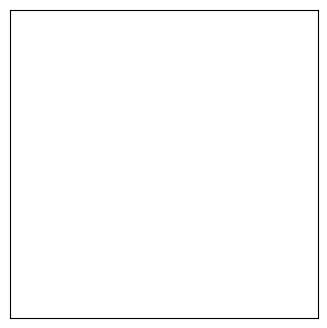

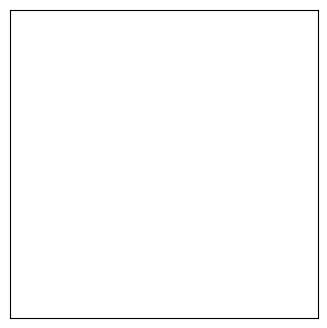

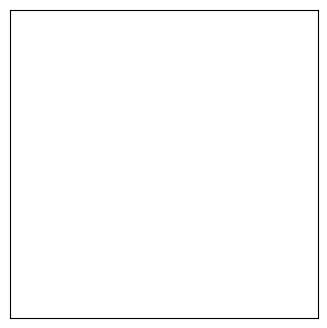

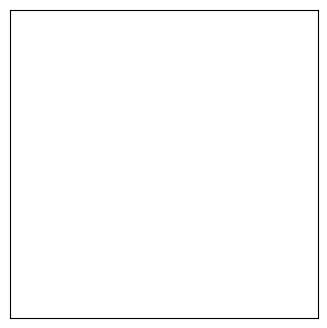

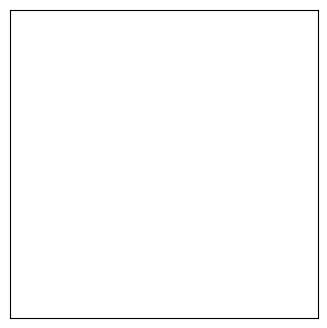

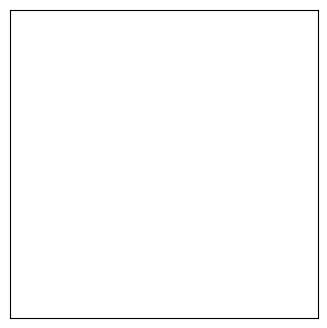

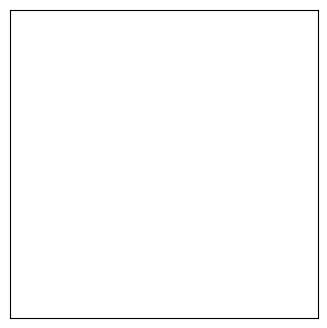

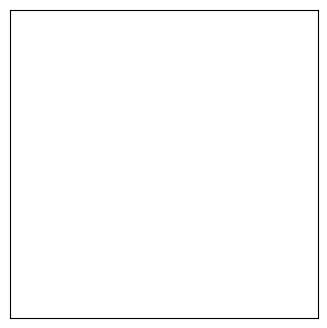

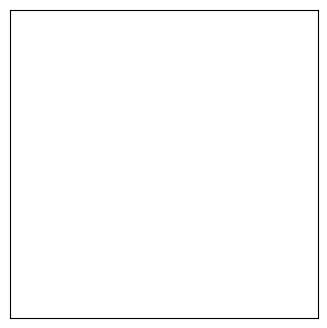

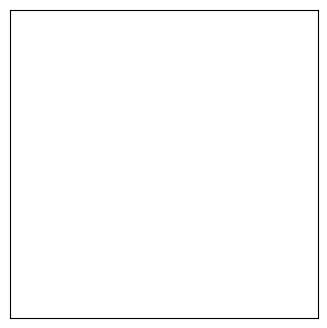

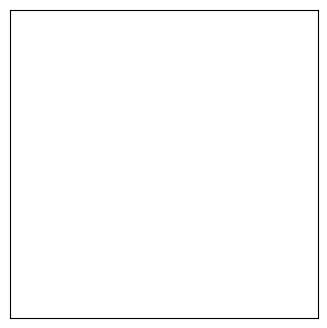

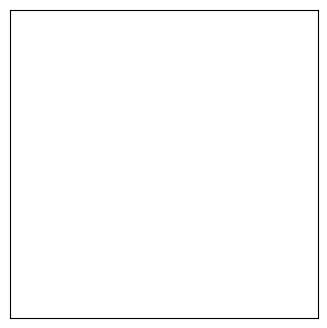

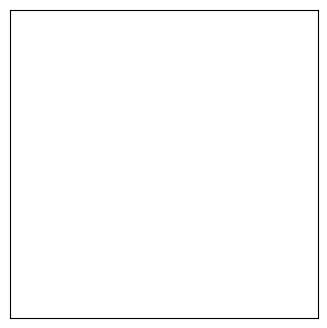

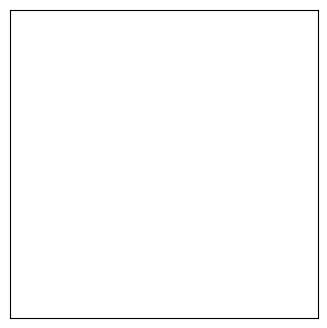

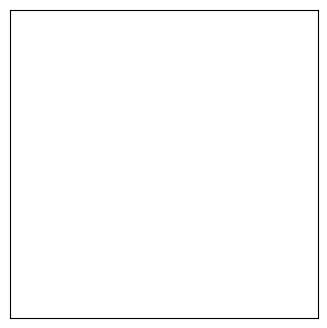

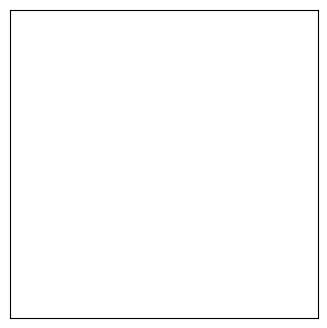

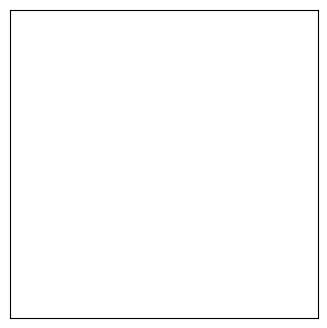

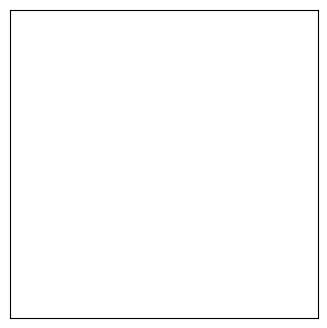

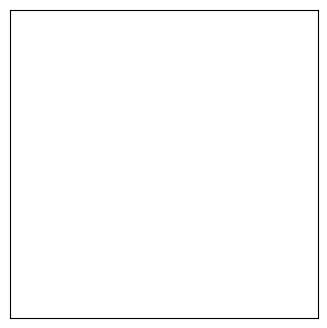

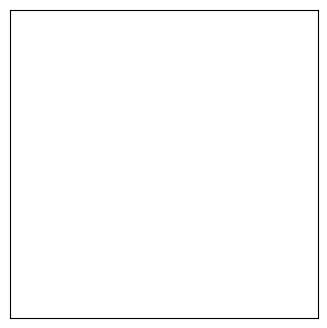

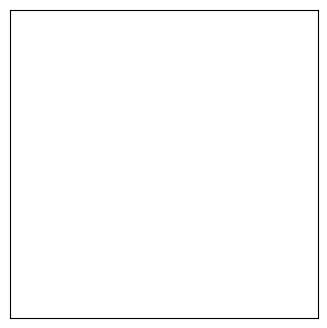

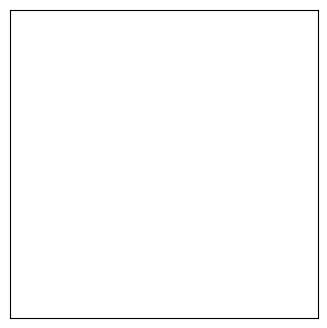

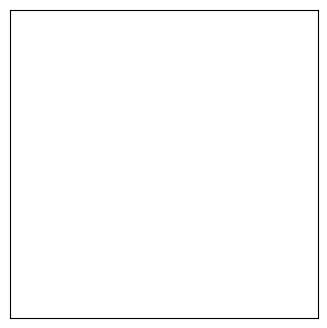

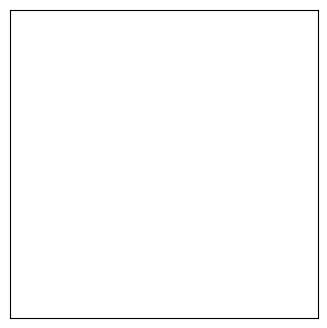

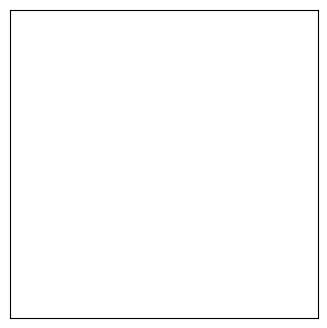

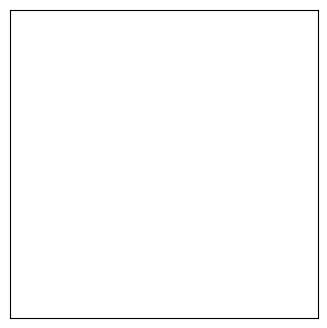

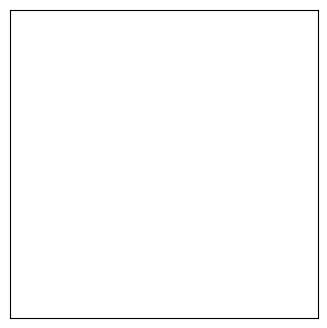

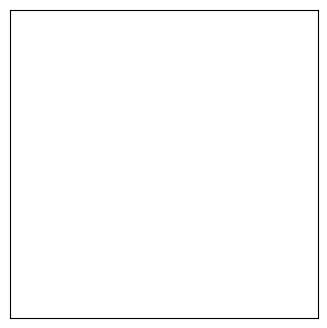

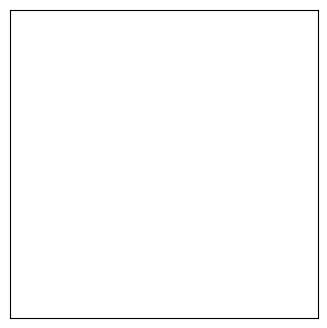

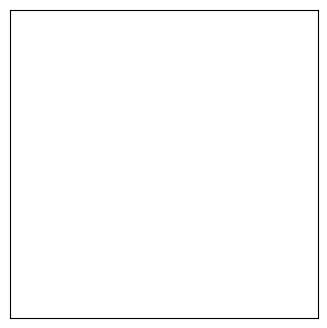

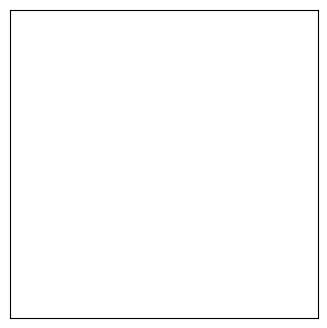

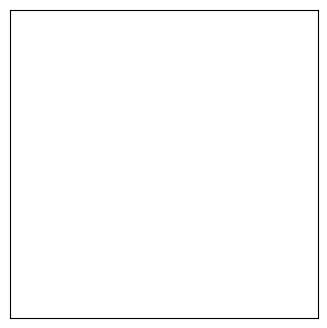

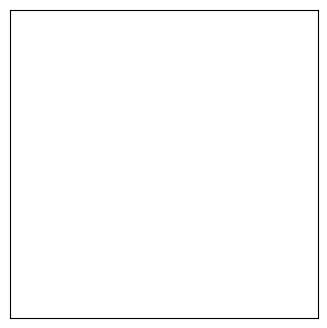

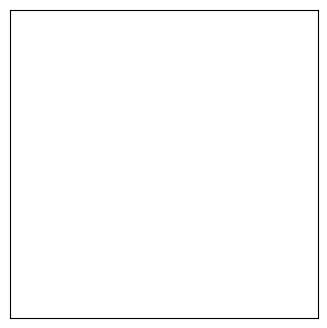

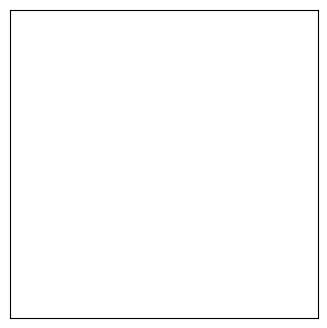

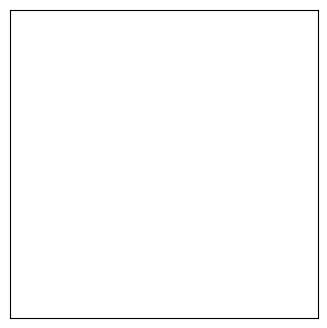

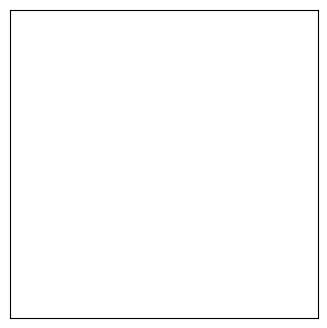

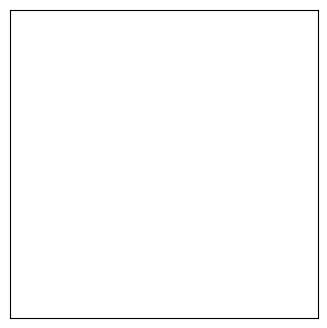

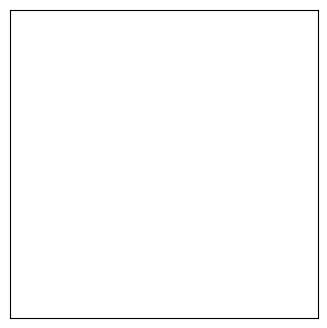

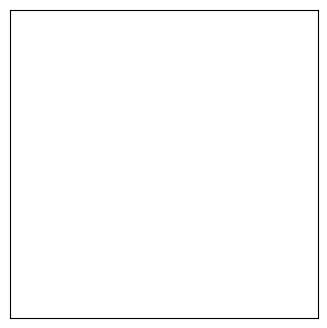

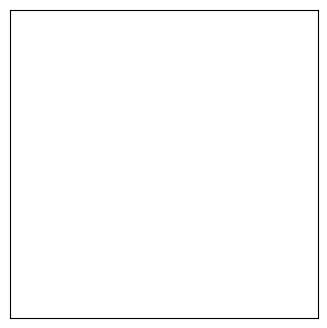

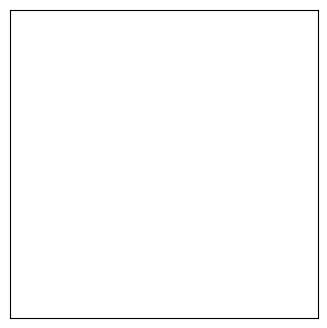

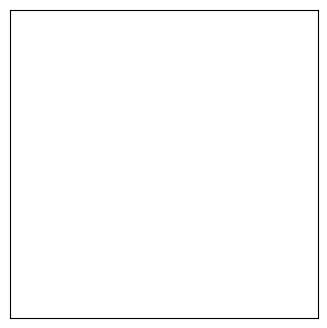

In [6]:
result_path = '/ssd/disk/PreferenceDiffusion/eval_ryan'

# eval_name = 'mcts-0805_1542'
# scene_name = 'scene-21'


eval_name = 'mcts-0803_0959'
#for scene_name in sorted([s for s in os.listdir(os.path.join(result_path, eval_name)) if s.startswith('scene-')]):
for sidx in np.arange(100):
    scene_name = 'scene-%d'%sidx

    data_path = os.path.join(result_path, eval_name, scene_name)
    img_files = sorted([f for f in os.listdir(data_path) if f.startswith('nv_top_real')])

    images = []
    inputs = []
    for img_file in img_files:
        img_path = os.path.join(data_path, img_file)
        img = np.array(Image.open(img_path))
        seg = np.array(Image.open(img_path.replace('nv_top_real_', 'top_seg_')))

        fg_mask = (1-(seg.sum(2)==334))
        img_rmbg = img * fg_mask[:, :, None]

        images.append(img)
        inputs.append(img_rmbg/255.)
    scores = get_scores(inputs)
    if len(scores) < 4:
        continue

    plt.figure(figsize=(12,4))
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

    for k, score in enumerate(scores):
        plt.text(480*k+180, 360+50, '%.3f'%score, fontsize=10)
    plt.imshow(np.concatenate(images, 1))
    # plt.imshow(np.concatenate(inputs, 1))
    if not os.path.isdir('/ssd/disk/PreferenceDiffusion/user_study/%s'%eval_name):
        os.makedirs('/ssd/disk/PreferenceDiffusion/user_study/%s'%eval_name)
    plt.savefig('/ssd/disk/PreferenceDiffusion/user_study/%s/%s'%(eval_name, scene_name), bbox_inches='tight')
    plt.cla()

In [90]:
for mname in os.listdir('/ssd/disk/PreferenceDiffusion/best'):
    print(mname)
    scenes = os.listdir('/ssd/disk/PreferenceDiffusion/best/%s'%mname)
    scene_names = [s.split('.')[0] for s in scenes]
    print(scene_names)

mcts-0802_2103
['scene-9', 'scene-21', 'scene-69', 'scene-0', 'scene-39']
mcts-0803_0959
['scene-62', 'scene-42', 'scene-23', 'scene-71', 'scene-53', 'scene-22']
mcts-0803_1602
['scene-57', 'scene-96', 'scene-13', 'scene-16', 'scene-44', 'scene-0', 'scene-32', 'scene-47', 'scene-53']
mcts-0803_0734
['scene-34', 'scene-12', 'scene-68', 'scene-40', 'scene-37', 'scene-13', 'scene-29', 'scene-14', 'scene-70', 'scene-2', 'scene-28', 'scene-1', 'scene-59', 'scene-8', 'scene-53']


In [7]:
import cv2

In [8]:
result_path = '/ssd/disk/PreferenceDiffusion/eval_ryan'

scene_index = 0
for eval_name in [m for m in os.listdir('/ssd/disk/PreferenceDiffusion/best') if m.startswith('mcts-')]:
    scenes = os.listdir('/ssd/disk/PreferenceDiffusion/best/%s'%eval_name)
    scene_names = [s.split('.')[0] for s in scenes]
    for scene_name in scene_names:
        data_path = os.path.join(result_path, eval_name, scene_name)
        img_files = sorted([f for f in os.listdir(data_path) if f.startswith('nv_top_real')])
        
        images = []
        inputs = []
        for img_file in img_files:
            img_path = os.path.join(data_path, img_file)
            img = np.array(Image.open(img_path))
            seg = np.array(Image.open(img_path.replace('nv_top_real_', 'top_seg_')))

            fg_mask = (1-(seg.sum(2)==334))
            img_rmbg = img * fg_mask[:, :, None]

            images.append(img)
            inputs.append(img_rmbg/255.)
        scores = get_scores(inputs)
        
        images_sorted, scores_sorted = zip(*sorted(zip(images, scores), key=lambda x: x[1]))
        
        if not os.path.isdir('/ssd/disk/PreferenceDiffusion/selected/scene%02d'%scene_index):
            os.makedirs('/ssd/disk/PreferenceDiffusion/selected/scene%02d'%scene_index)
            
        for idx in range(len(images_sorted)):
            score = np.round(scores_sorted[idx] * 1000).astype(int)
            save_name = '/ssd/disk/PreferenceDiffusion/selected/scene%02d/image%02d_%d.png' %(scene_index, idx, score)
            cv2.imwrite(save_name, cv2.cvtColor(images_sorted[idx], cv2.COLOR_RGB2BGR))
        #cv2.imwrite('result_%s.jpg'%env, cv2.cvtColor((fimg*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
        scene_index += 1